In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imageio
from sif_multinput import KNN

import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"

ModuleNotFoundError: No module named 'imageio'

In [2]:
#----- Plotting Function ------
def plot_results(U, Y, knn_sgd, knn_sif, knn_ekf):
    plt.rcParams["figure.figsize"] = (20,10)
    plt.suptitle("Data Fit", fontsize=22)
    plt.scatter(U, Y, c='b', s=5)
    plt.plot(U, knn_sif.feedforward(U), c='g', lw=3, label='ESIF: {} epochs'.format(nepochs))
    plt.plot(U, knn_ekf.feedforward(U), c='r', lw=3, label='EKF: {} epochs'.format(nepochs))
    plt.plot(U, knn_sgd.feedforward(U), c='k', ls=':', lw=2, label='SGD: {} epochs'.format(nepochs))
    plt.grid(True)
    plt.legend(fontsize=22)
    plt.show()

    #------Calculate scores------
    compute_rms = lambda Predict, Y: np.sqrt(np.mean(np.square(Y - Predict)))

    rms = pd.DataFrame()
    rms.loc[0,"ESIF"] = compute_rms(Y, knn_sif.feedforward(U).ravel())
    rms.loc[0,"SGD"] = compute_rms(Y, knn_sgd.feedforward(U).ravel())
    rms.loc[0,"EKF"] = compute_rms(Y, knn_ekf.feedforward(U).ravel())

    print("-----RMS values------")
    print(rms)

    df = pd.DataFrame()
    df['SGD_RMS'] = knn_sgd.RMS
    df["SIF_RMS"] = knn_sif.RMS
    df["EKF_RMS"] = knn_ekf.RMS
    fig = df.plot()
    fig.show()

    df_sif = pd.DataFrame()
    df_sif["delta_values"] = knn_sif.delta_vals
    df_sif["RMS"] = knn_sif.RMS_batch
    fig_sif = df_sif.plot()

    fig_sif.show()


----Neural Network Structure----
Input --> 4neurons --> 1 neuron --> Output
epochs: 300
batch_size: 1



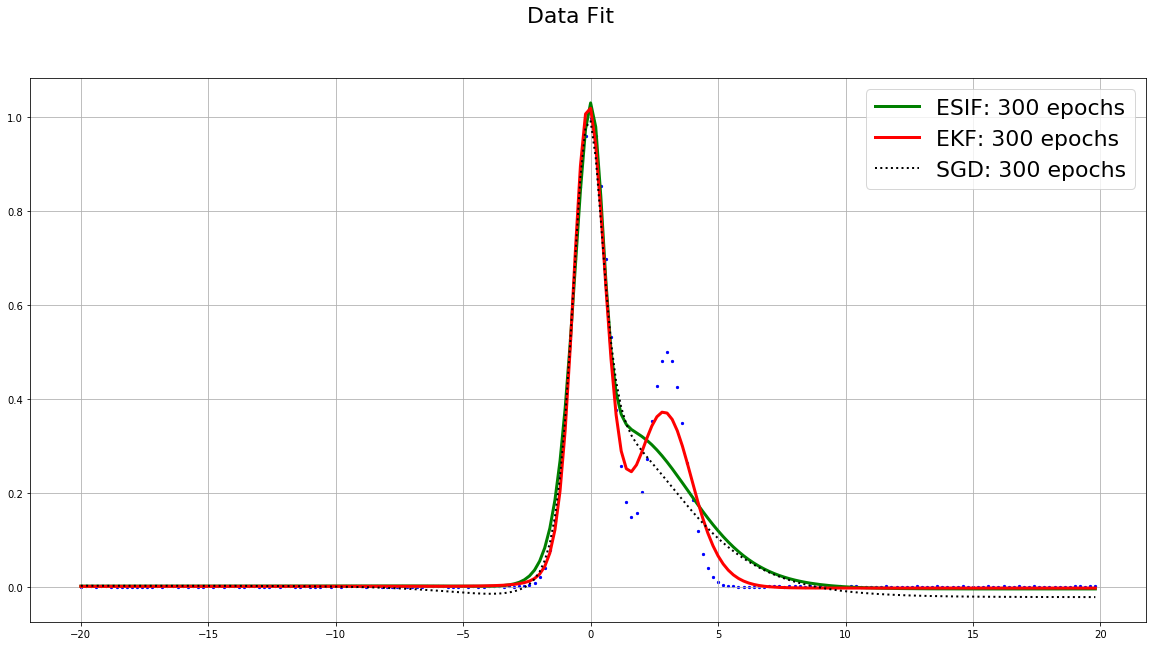

-----RMS values------
       ESIF      SGD       EKF
0  0.047856  0.05221  0.026582


In [4]:
stdev = 0.00055
U = np.arange(-20, 20, 0.2)

sig = lambda V: (1 + np.exp(-V))**-1
# Y =  (sig(U * 0.4) + 0.1) + (sig(U * -0.2) + 0.4)
Y = np.exp(-U**2) + 0.5*np.exp(-(U-3)**2) + np.random.normal(0, stdev, len(U))

# Create two identical KNN's that will be trained differently
# knn_ekf = KNN(nu=1, ny=1, nl=1, neuron='relu')
hidden_layer = 4
knn_sif = KNN(nu=1, ny=1, nl=hidden_layer, neuron='logistic')
knn_ekf = KNN(nu=1, ny=1, nl=hidden_layer, neuron='logistic')
knn_sgd = KNN(nu=1, ny=1, nl=hidden_layer, neuron='logistic')
nepochs = 300

print("----Neural Network Structure----")
print(f"Input --> {hidden_layer}neurons --> 1 neuron --> Output")
print(f"epochs: {nepochs}")
print("batch_size: 1")
print("")

# Train
mu = 0.00001
knn_sif.train(nepochs=nepochs, U=U, Y=Y, method='sif', P=(mu/0.01), Q=mu*0.0001, R=(mu/0.1))
knn_ekf.train(nepochs=nepochs, U=U, Y=Y, method='ekf', P=(mu/0.01), Q=mu*0.0001, R=(mu/0.1))
knn_sgd.train(nepochs=nepochs, U=U, Y=Y, method='sgd', step=0.1)

# Evaluation
plot_results(U, Y, knn_sgd, knn_sif, knn_ekf)


## Optimizer illustrations

### Loss Function Graph

No handles with labels found to put in legend.


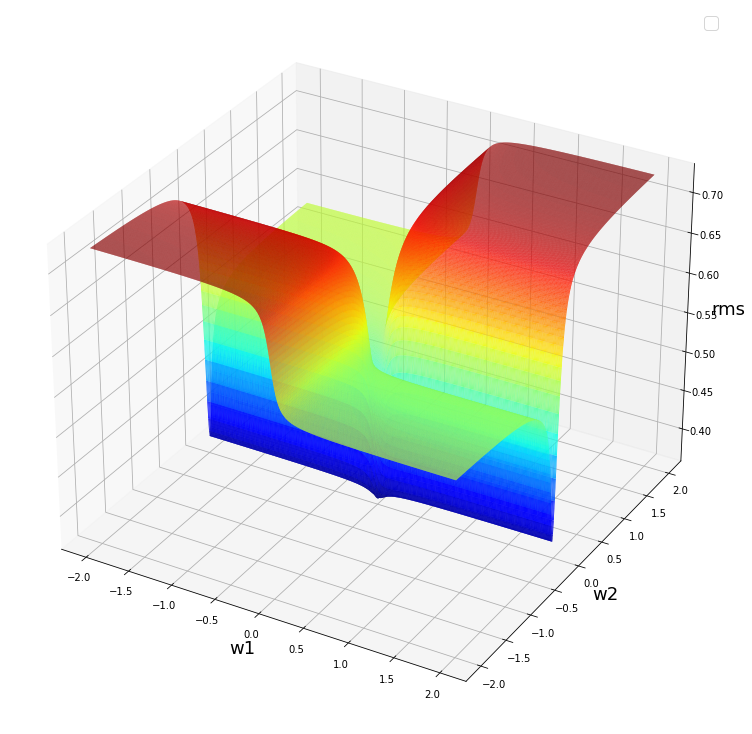

In [11]:
df_opt = pd.DataFrame(columns=["rms", "w1", "w2"])
compute_rms = lambda Predict, Y: np.sqrt(np.mean(np.square(Y - Predict)))

U = np.arange(-20, 20, 0.2)
# Y = np.exp(-U**2) + 0.5*np.exp(-(U-3)**2) + np.random.normal(0, stdev, len(U))
sig = lambda V: np.tanh(V)
Y =  (sig(U * 0.4) + 0.1) + (sig(U * -0.2) + 0.4)


for w1 in np.arange(-2, 2, 0.01):
    for w2 in np.arange(-2, 2, 0.01):
        NN = KNN(nu=1, ny=1, nl=2, neuron='tanh')
        NN.W = [np.array([[ w1, 0.1], [w2, 0.1]]), np.array([[ 0.1, 0.5, 0.1]])]
        predict = NN.feedforward(U)
        rms = compute_rms(predict, Y)
        df_opt = df_opt.append({"rms": rms, "w1": w1, "w2": w2}, ignore_index=True)

df_opt.rms.min()

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


X = np.arange(-2, 2, 0.01)
Y = np.arange(-2, 2, 0.01)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X ** 2 + X ** 2)
Z = np.sin(R)
fig = plt.figure()

ax = Axes3D(fig)

df_opt.set_index("w1")
ax.plot_trisurf(df_opt.w1, df_opt.w2, df_opt.rms, cmap=cm.jet, linewidth=0.1)

ax.set_xlabel("w1",fontsize=18)
ax.set_ylabel("w2",fontsize=18)
ax.set_zlabel("rms",fontsize=18)
plt.legend(fontsize=18)

In [14]:
# Train all thre optimizers
stdev = 0.00055
U = np.arange(-20, 20, 0.2)
# Y = np.exp(-U**2) + 0.5*np.exp(-(U-3)**2) + np.random.normal(0, stdev, len(U))
sig = lambda V: np.tanh(V)
Y =  (sig(U * 0.4) + 0.1) + (sig(U * -0.2) + 0.4)

n_epochs = 10
gradient_step = round(n_epochs/10)

print("----Neural Network Structure----")
print(f"Input --> {2} neurons --> 1 neuron --> Output")
print(f"epochs: {n_epochs}")
print("batch_size: 1")
print("Initial weights:", )
print("")

df_arrows = pd.DataFrame()

for method in ['sif', 'ekf', 'sgd']:
    print(f"-------{method}-------")
    NN = KNN(nu=1, ny=1, nl=2, neuron='tanh')
    NN.W = [np.array([[-0.7, 0.1], [-0.7, 0.1]]), np.array([[ 0.1, 0.5, 0.1]])]
    NN.train(nepochs=n_epochs, U=U, Y=Y, method=method, P=10, Q=0.0001, R=10, pulse_T=0.75, gradient_testing=True)
    print("Initial weights:", NN.W_hist[0])
    rms = NN.RMS
    print("rms:", rms[-1])
    rms = [rms[i]for i in range(0, len(rms), gradient_step)]
    df_arrows[method+'_rms'] = rms
    print("weights:", NN.W)
    w1 = [NN.W_hist[i,0] for i in range(0, NN.W_hist.shape[0], gradient_step)]
    w2 = [NN.W_hist[i,2] for i in range(0, NN.W_hist.shape[0], gradient_step)]
    df_arrows[method+'_w1'] = w1
    df_arrows[method+'_w2'] = w2



----Neural Network Structure----
Input --> 2 neurons --> 1 neuron --> Output
epochs: 10
batch_size: 1
Initial weights:

-------sif-------
Initial weights: [-0.7  0.1 -0.7  0.1  0.1  0.5  0.1]
rms: 0.5293864337084985
weights: [array([[-0.07575657,  0.1       ],
       [ 1.09661312,  0.1       ]]), array([[0.1, 0.5, 0.1]])]
-------ekf-------
Initial weights: [-0.7  0.1 -0.7  0.1  0.1  0.5  0.1]
rms: 0.3627149078936842
weights: [array([[ 0.42137092,  0.1       ],
       [-0.00759809,  0.1       ]]), array([[0.1, 0.5, 0.1]])]
-------sgd-------
Initial weights: [-0.7  0.1 -0.7  0.1  0.1  0.5  0.1]
rms: 0.6490683052228193
weights: [array([[1.42972894, 0.1       ],
       [1.04541907, 0.1       ]]), array([[0.1, 0.5, 0.1]])]


sif_rms    0.529386
sif_w1    -0.075757
sif_w2     1.096613
ekf_rms    0.362715
ekf_w1     0.421371
ekf_w2    -0.007598
sgd_rms    0.649068
sgd_w1     1.429729
sgd_w2     1.045419
Name: 10, dtype: float64


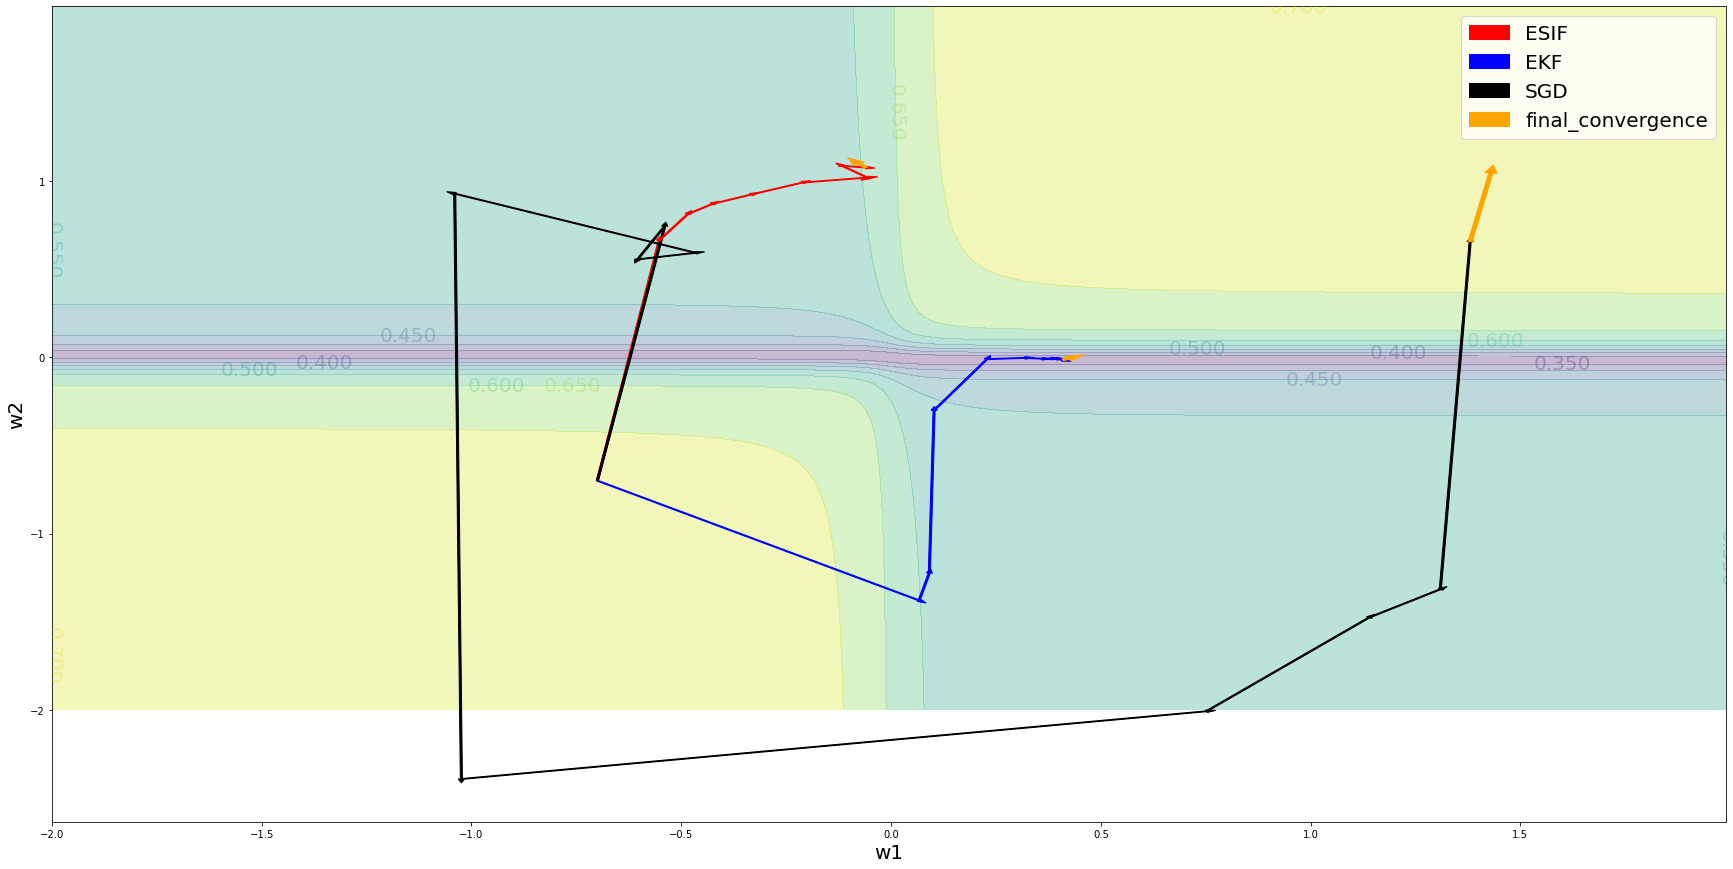

In [15]:
import matplotlib.patches as mpatches

w1=[]
w2=[]
loss = []

length = len(np.arange(-2, 2, 0.01))
for i in range(0, df_opt.shape[0], length):
        w1.append(df_opt.w1[i:i+length])
        w2.append(df_opt.w2[i:i+length])
        loss.append(df_opt.rms[i:i+length])
w1 = np.asarray(w1)
w2 = np.asarray(w2)
loss = np.asarray(loss)

plt.figure(figsize=(30, 15))

esif = mpatches.Patch(color='red', label='ESIF')
ekf = mpatches.Patch(color='blue', label='EKF')
sgd = mpatches.Patch(color='black', label='SGD')
f_converge = mpatches.Patch(color='orange', label='final_convergence')

plt.legend(handles=[esif, ekf, sgd, f_converge], fontsize=20)
cp = plt.contourf(w1, w2, loss, alpha=0.3)
plt.clabel(cp, inline=1, fontsize=20)
plt.xlabel('w1',fontsize=20)
plt.ylabel('w2',fontsize=20)

for i in range(1,df_arrows.shape[0]):
        # Paint last arrows to orange
        if i+1 == df_arrows.shape[0]:
                plt.arrow(x=df_arrows.loc[i-1, 'sif_w1'], y=df_arrows.loc[i-1, 'sif_w2'], dx=df_arrows.diff().loc[i, 'sif_w1'], dy=df_arrows.diff().loc[i, 'sif_w2'], width=.01, color='Orange')
                plt.arrow(x=df_arrows.loc[i-1, 'ekf_w1'], y=df_arrows.loc[i-1, 'ekf_w2'], dx=df_arrows.diff().loc[i, 'ekf_w1'], dy=df_arrows.diff().loc[i, 'ekf_w2'], width=.01, color='Orange')
                plt.arrow(x=df_arrows.loc[i-1, 'sgd_w1'], y=df_arrows.loc[i-1, 'sgd_w2'], dx=df_arrows.diff().loc[i, 'sgd_w1'], dy=df_arrows.diff().loc[i, 'sgd_w2'], width=.01, color='Orange')
                break

        plt.arrow(x=df_arrows.loc[i-1, 'sif_w1'], y=df_arrows.loc[i-1, 'sif_w2'], dx=df_arrows.diff().loc[i, 'sif_w1'], dy=df_arrows.diff().loc[i, 'sif_w2'], width=.005, color='Red', label='esif')
        plt.arrow(x=df_arrows.loc[i-1, 'ekf_w1'], y=df_arrows.loc[i-1, 'ekf_w2'], dx=df_arrows.diff().loc[i, 'ekf_w1'], dy=df_arrows.diff().loc[i, 'ekf_w2'], width=.005, color='Blue', label='ekf')
        plt.arrow(x=df_arrows.loc[i-1, 'sgd_w1'], y=df_arrows.loc[i-1, 'sgd_w2'], dx=df_arrows.diff().loc[i, 'sgd_w1'], dy=df_arrows.diff().loc[i, 'sgd_w2'], width=.005, color='Black', label='sgd')
        # plt.savefig(f"./gif/opt_comparison{i}.png")

# plt.close()
print(df_arrows.iloc[-1,:])
# Build GIF

# with imageio.get_writer('mygif.gif', mode='I') as writer:
#     for num in range(1,10):
#         image = imageio.imread(f"./gif/opt_comparison{num}.png")
#         writer.append_data(image)

![SegmentLocal](images/animation.gif "segment")